In [3]:
import numpy as np
import cv2
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

## Load and Visualize the Data

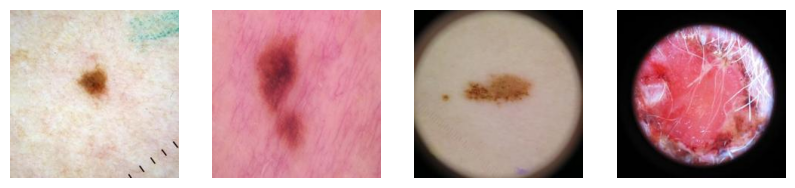

In [4]:
path_to_benign_images_train = 'data/train/Benign'
path_to_malignant_images_train = 'data/train/Malignant'
path_to_benign_images_test = 'data/test/Benign'
path_to_malignant_images_test = 'data/test/Malignant'

def load_and_display_images(image_paths):
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

benign_images_train = [os.path.join(path_to_benign_images_train, img) for img in os.listdir(path_to_benign_images_train)]
malignant_images_train = [os.path.join(path_to_malignant_images_train, img) for img in os.listdir(path_to_malignant_images_train)]
benign_images_test = [os.path.join(path_to_benign_images_test, img) for img in os.listdir(path_to_benign_images_test)]
malignant_images_test = [os.path.join(path_to_malignant_images_test, img) for img in os.listdir(path_to_malignant_images_test)]
random.shuffle(benign_images_train)
random.shuffle(malignant_images_train)
load_and_display_images(benign_images_train[:2] + malignant_images_train[:2])

## Enhance image quality

## Preprocess the Images

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9324455/

\begin{equation}
I_{\text {norm }}=\left(I-\operatorname{Min}_I\right)\left(\frac{2}{\operatorname{Max}_I-\operatorname{Min}_I}\right)-1
\end{equation}

In [7]:
def normalize_image(image):
    MinI = np.min(image)
    MaxI = np.max(image)
    I_norm = ((image - MinI) * (2 / (MaxI - MinI))) - 1
    return I_norm

from tensorflow.keras.utils import Sequence
import math

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return math.ceil(len(self.image_paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for img_path in batch_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = normalize_image(img)
            images.append(img)
        
        return np.array(images), np.array(batch_labels)

batch_size = 64

train_gen = CustomDataGenerator(
    image_paths=np.concatenate((benign_images_train, malignant_images_train)),
    labels=np.concatenate((np.zeros(len(benign_images_train)), np.ones(len(malignant_images_train)))),
    batch_size=batch_size
)

test_gen = CustomDataGenerator(
    image_paths=np.concatenate((benign_images_test, malignant_images_test)),
    labels=np.concatenate((np.zeros(len(benign_images_test)), np.ones(len(malignant_images_test)))),
    batch_size=batch_size
)


## Model

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10
186/186 [==============================] - 147s 786ms/step - loss: 0.7863 - accuracy: 0.6819 - val_loss: 0.5886 - val_accuracy: 0.6495
Epoch 2/10
186/186 [==============================] - 145s 776ms/step - loss: 0.4738 - accuracy: 0.7801 - val_loss: 0.5072 - val_accuracy: 0.7285
Epoch 3/10
186/186 [==============================] - 150s 805ms/step - loss: 0.4307 - accuracy: 0.8053 - val_loss: 0.5359 - val_accuracy: 0.7160
Epoch 4/10
186/186 [==============================] - 146s 783ms/step - loss: 0.3960 - accuracy: 0.8227 - val_loss: 0.4145 - val_accuracy: 0.8285
Epoch 5/10
186/186 [==============================] - 144s 773ms/step - loss: 0.3797 - accuracy: 0.8374 - val_loss: 0.3866 - val_accuracy: 0.8300
Epoch 6/10
186/186 [==============================] - 147s 789ms/step - loss: 0.3466 - accuracy: 0.8463 - val_loss: 0.5144 - val_accuracy: 0.7675
Epoch 7/10
186/186 [==============================] - 146s 785ms/step - loss: 0.3416 - accuracy: 0.8485 - val_loss: 0.3261 -

In [10]:
loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

32/32 [==============================] - 7s 229ms/step - loss: 0.3753 - accuracy: 0.8540
Test loss: 0.3753089904785156
Test accuracy: 0.8539999723434448


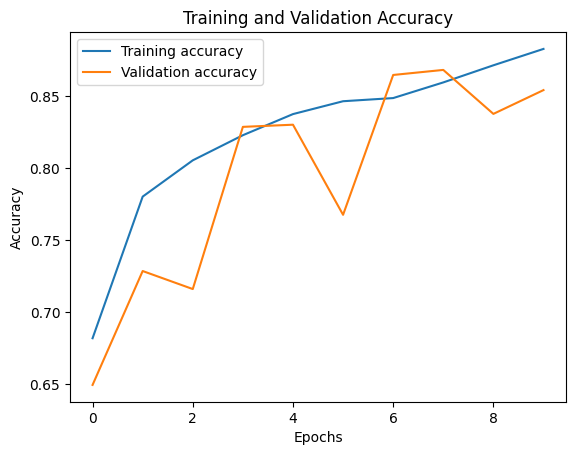

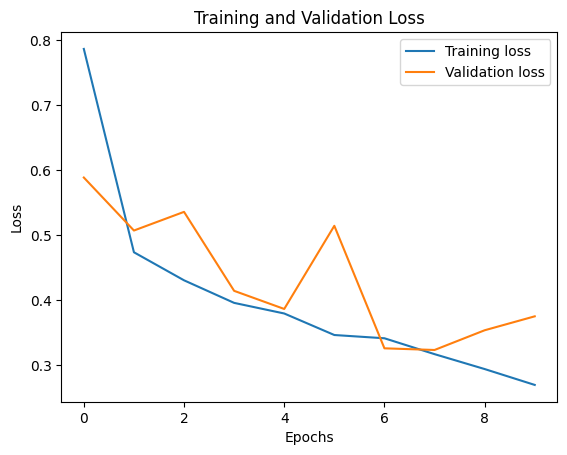

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
